In [1]:
import glob     #for checking dir content
import os       #for dir creation
from Functions import *
from GSModel import *
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import MaxPooling1D, Flatten, Dense, Conv1D,MaxPooling2D, Conv2D
from keras.layers import Dropout
import keras.metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import platform
from datetime import datetime
from sklearn.metrics import mean_squared_error
import configparser



In [2]:
#Load genomic data and phenotypes
config_path = "./DS_config.ini"
config = configparser.ConfigParser()
if platform.system().lower() == "windows":
    print(config_path)
    config.read(config_path)
else:
    config.read(config_path)

try:
    geno_data = pd.read_csv(config["PATH"]["genotype"], sep="\t")  # pd.read_csv("../fitted_genos.csv",sep="\t")
    pheno_data = pd.read_csv(config["PATH"]["phenotype"], sep="\t")  # pd.read_csv("../phenotypes.csv",sep="\t")
except:
    try:
        print("Using backup path (for trouble shooting)")
        print(config["BACKUP_PATH"]["genotype"])
        geno_data = pd.read_csv(config["BACKUP_PATH"]["genotype"],
                                sep="\t")  # pd.read_csv("../fitted_genos.csv",sep="\t")
        pheno_data = pd.read_csv(config["BACKUP_PATH"]["phenotype"],
                                    sep="\t")  # pd.read_csv("../phenotypes.csv",sep="\t")
    except:
        print("No valid path found.")
        exit()
geno_data = decoding(geno_data)

./DS_config.ini
Using backup path (for trouble shooting)
E:\learning resource\PhD\genomic data\Sugarcane\qc_genotypes.csv


In [3]:
path = "E:/learning resource/PhD/HPC_Results/CNN/backup/2013-2015_vs_2017/models/"
trait_name = "TCHBlup"
region = "all"
method = "CNN"
model_path = path + "{}_{}_{}_model.json".format(trait_name,method,region)
weights_path = model_path + ".h5"
print(weights_path)
#region_index = "all"
#trait = "TCHBlup"
f_json = open(model_path,"r")
model_json = f_json.read()
f_json.close()
trained_model = keras.models.model_from_json(model_json)
trained_model.load_weights(weights_path)

E:/learning resource/PhD/HPC_Results/CNN/backup/2013-2015_vs_2017/models/TCHBlup_CNN_all_model.json.h5


Process feature data

In [4]:
"""
traits = config["BASIC"]["traits"]
train_year = config["BASIC"]["train"]
valid_year = config["BASIC"]["valid"]

filtered_data = read_pipes(geno_data, pheno_data, train_year + valid_year)
non_genetic_factors = [x for x in pheno_data.columns if x not in traits]
print("Detected non-genetic factors from phenotype file: ",non_genetic_factors)

dropout = [x for x in non_genetic_factors if
                   x not in ["Region","Series"]] + ["Sample"] # config["BASIC"]["drop"].split("#") + ['Sample']
print("Removing useless non-genetic factors: {}".format(dropout))
filtered_data.drop(dropout, axis=1, inplace=True)
"""
def select_subset(config,geno,pheno,select_by):
    traits = config["BASIC"]["traits"]
    train_year = get_years(config["BASIC"]["train"])
    valid_year = get_years(config["BASIC"]["valid"])
    non_genetic_factors = [x for x in pheno.columns if x not in traits]
    print("Detected non-genetic factors from phenotype file: ", non_genetic_factors)
    filtered_data = read_pipes(geno, pheno, train_year + valid_year)
    dropout = [x for x in non_genetic_factors if
               x not in ["Region", "Series"]] + ["Sample"]  # config["BASIC"]["drop"].split("#") + ['Sample']
    print("Removing useless non-genetic factors: {}".format(dropout))
    filtered_data.drop(dropout, axis=1, inplace=True)

    select_data = filtered_data.query('Region in @select_by').drop(["Region"],axis=1)

    return select_data

region_set = pheno_data.Region.unique()
if region == "all":
    region_index = region_set
train_year = get_years(config["BASIC"]["train"])
valid_year = get_years(config["BASIC"]["valid"])
selected_data = select_subset(config,geno_data,pheno_data,region_index)
drop_traits = ["CCSBlup","FibreBlup"]
print(selected_data.columns)
selected_data.dropna(subset=[trait_name],axis=0,inplace=True)
#print(selected_data.columns)
selected_data.drop(drop_traits,axis=1,inplace=True)
train_targets = selected_data.query("Series in @train_year")[trait_name]
valid_targets = selected_data.query("Series in @valid_year")[trait_name]
train_features = selected_data.query("Series in @train_year").drop(["Series",trait_name],axis=1)
valid_features = selected_data.query("Series in @valid_year").drop(["Series",trait_name],axis=1)
print(train_features.columns)
print(train_features.shape)

Detected non-genetic factors from phenotype file:  ['Series', 'Region', 'Trial', 'Crop', 'Clone']
Got selected years: [2013, 2014, 2015, 2017]
Removing useless non-genetic factors: ['Trial', 'Crop', 'Clone', 'Sample']
Index(['Series', 'CCSBlup', 'TCHBlup', 'FibreBlup', '0', '1', '2', '3', '4',
       '5',
       ...
       '26076', '26077', '26078', '26079', '26080', '26081', '26082', '26083',
       '26084', '26085'],
      dtype='object', length=26090)
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '26076', '26077', '26078', '26079', '26080', '26081', '26082', '26083',
       '26084', '26085'],
      dtype='object', length=26086)
(1200, 26086)


In [6]:
X = np.expand_dims(valid_features,axis=2)
length = len(valid_targets)
outputs = np.reshape(trained_model.predict(X), (length,))
#print(outputs)
print(np.corrcoef(outputs,valid_targets)[0,1])

0.3733788069301798


In [19]:
from keras import models
layer_outputs = [layer.output for layer in trained_model.layers[:3]]
activation_model = models.Model(inputs=trained_model.input, outputs=layer_outputs)
for layer in trained_model.layers:
    print(layer)

In [93]:
activations = activation_model.predict(X)
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(400, 1449, 128)


3.9846
(1, 400, 1449, 128)


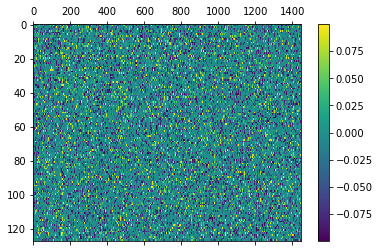

In [94]:
print(valid_targets.iloc[1])
img_data = np.expand_dims(first_layer_activation,axis=0)
print(img_data.shape)
o,n,m,c = img_data.shape
reshaped_img = np.reshape(img_data,(o,c,m,n))
reshaped_img = np.where((-0.1 < reshaped_img)&( reshaped_img< 0.1), reshaped_img, 0)
#reshaped_img[abs(reshaped_img) > 0] = 1
figure = plt.figure()
axes = figure.add_subplot(111) 
#img = axes.matshow(img_data[0,:,:,1],cmap='viridis', aspect='auto')
img = axes.matshow(reshaped_img[0,:,:,1], aspect='auto') #,cmap='viridis'
figure.colorbar(img) 
#plt.savefig("../../HPC_Results/CNN/backup/TCH_all_channel_128_conv_onemb.png",pad_inches=0.4)

(1, 1449, 400)
(400, 1449)


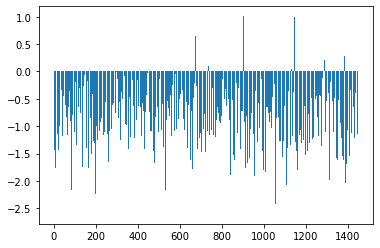

In [95]:
snp_importance = reshaped_img.sum(axis=1)
print(snp_importance.shape)
snp_importance = np.reshape(snp_importance,[n,m])
print(snp_importance.shape)
fig_imp = plt.figure()
axe_imp = fig_imp.add_subplot(111)
img_imp = axe_imp.bar(x=range(m),height=snp_importance[0])
#plt.savefig("../../HPC_Results/CNN/backup/TCH_all_channel_128_conv_onemb_sample1_numeric.png",pad_inches=0.4)

In [96]:
print(sorted(valid_targets))
sorted_index = sorted(range(len(valid_targets.tolist())),key=lambda k:valid_targets.tolist()[k],reverse=True)
print(sorted_index)

[-25.9599, -24.6608, -23.2964, -21.271, -21.2262, -19.8279, -19.7594, -19.4562, -17.5365, -16.9652, -16.8492, -16.7702, -16.132, -15.4189, -14.7002, -14.0958, -13.7836, -13.5745, -13.3182, -12.8324, -12.5178, -12.1499, -11.975, -11.8863, -11.6773, -11.1476, -10.9256, -10.7235, -10.5502, -10.4794, -10.3085, -10.0543, -9.8559, -9.7136, -9.6722, -9.6165, -9.1852, -9.1143, -9.0371, -8.9883, -8.9518, -8.936, -8.8746, -8.5274, -8.3827, -8.2591, -8.2199, -8.2021, -8.1176, -8.1014, -8.0755, -7.9945, -7.9514, -7.907, -7.5929, -7.254, -7.1974, -7.064, -6.892, -6.8648, -6.7858, -6.7425, -6.6982, -6.5952, -6.4955, -6.477, -6.3892, -6.2988, -6.2009, -6.1634, -5.8325, -5.415, -5.3461, -5.3373, -5.2956, -5.2605, -5.2138, -5.2042, -5.0776, -5.0775, -5.048, -5.0467, -4.9759, -4.9661, -4.9505, -4.9376, -4.9202, -4.8928, -4.8628, -4.7102, -4.6152, -4.4015, -4.3519, -4.3213, -4.2715, -4.2582, -4.2288, -4.1904, -4.1652, -4.0944, -4.0549, -3.9639, -3.9239, -3.9138, -3.7733, -3.7652, -3.7368, -3.6727, -3.671

(400, 1449)


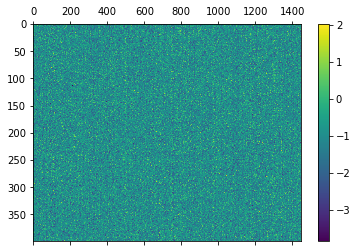

In [97]:
all_sample_importance = snp_importance[sorted_index] #np.expand_dims(snp_importance,axis=0)
fig_as = plt.figure()
print(all_sample_importance.shape)
axe_as = fig_as.add_subplot(111)
img_as = axe_as.matshow(all_sample_importance, aspect='auto')
fig_as.colorbar(img_as)
#plt.savefig("../../HPC_Results/CNN/backup/TCH_all_channel_128_conv_onemb_allsample_sort.png",pad_inches=0.4)


In [62]:
layer_names = []
for layer in trained_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')



MemoryError: Unable to allocate 36.0 GiB for an array with shape (34776, 139104) and data type float64